In [1]:
%reset
import sys, os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = '0.9'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']="False"

# Change the current working directory to the desired path
os.chdir('/mnt/home/spandey/ceph/GODMAX/src/')
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as np
import jax.numpy as jnp
import colossus 
from jax import vmap, grad
%matplotlib inline
import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')

%load_ext autoreload
%autoreload 2

import getdist
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import MixtureND

import matplotlib
%matplotlib inline



/tmp/ipykernel_67988/1546951311.py:9: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
# samples_Y1 = np.load('/mnt/home/spandey/ceph/GODMAX/data/DES_Y1_3x2pt_chain.npy')
import pickle as pk
# samples_Y1 = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y1.pk', 'rb'))['samples']
# samples_Y6 = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y6.pk', 'rb'))['samples']

samples_Y1 = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y1_FINALSET.pk', 'rb'))['samples']
samples_Y6 = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y6_FINALSET.pk', 'rb'))['samples']

samples_Y1_xipxim_only = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y1_FINALSET_xipxim_only.pk', 'rb'))['samples']
samples_Y6_xipxim_only = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y6_FINALSET_xipxim_only.pk', 'rb'))['samples']

# samples_Y1_gty_only = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y1_FINALSET_gty_only.pk', 'rb'))['samples']
# samples_Y6_xipxim_only = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y6_FINALSET_xipxim_only.pk', 'rb'))['samples']



In [3]:
# samples_Y1.keys()
settings = {'ignore_rows': 0.0, 'smooth_scale_1D': 0.3, 'smooth_scale_2D': 0.3}
# param_name_dict = 
cosmo_params_vary_names = ['Om0', 'Ob0', 'H0', 'ns', 'sigma8']
# sims_params_vary_names = ['theta_ej_0', 'theta_co_0','nu_z', 'gamma_rhogas','mu_beta','nu_theta_ej_M','eta_star','alpha_nt']
# sims_params_vary_names = ['theta_ej_0', 'theta_co_0','nu_z', 'gamma_rhogas','mu_beta', 'log10_Mc0','eta_star','alpha_nt']
sims_params_vary_names = ['theta_ej_0', 'theta_co_0','nu_z', 'nu_theta_ej_z', 'gamma_rhogas','mu_beta', 'log10_Mc0','eta_star','alpha_nt', 'nu_theta_ej_M']

IA_params_vary_names = ['A_IA', 'eta_IA']
mult_shear_vary_names = ['mult_shear_bias_bin1', 'mult_shear_bias_bin2', 'mult_shear_bias_bin3', 'mult_shear_bias_bin4', 'mult_shear_bias_bin5'] 
Delta_shear_vary_names = ['Delta_z_bias_bin1', 'Delta_z_bias_bin2', 'Delta_z_bias_bin3', 'Delta_z_bias_bin4', 'Delta_z_bias_bin5']

param_names = cosmo_params_vary_names + sims_params_vary_names + IA_params_vary_names + mult_shear_vary_names + Delta_shear_vary_names
param_labels = [r'$\Omega_m$', r'$\Omega_b$', r'$H_0$', r'$n_s$', r'$\sigma_8$', r'$\theta_{\rm ej,0}$', r'$\theta_{\rm co,0}$', r'$\nu_z$', r'$\nu_{z, \theta_{\rm ej}}$', r'$\gamma$', r'$\mu_{\beta}$', r'$\log_{10}(M_{c,0})$', r'$\eta_{\star}$', r'$\alpha_{nt}$', r'$\nu_{M, \theta_{\rm ej}}$', r'$A_{IA}$', r'$\eta_{IA}$', r'$m_1$', r'$m_2$', r'$m_3$', r'$m_4$', r'$m_5$', r'$\Delta z_1$', r'$\Delta z_2$', r'$\Delta z_3$', r'$\Delta z_4$', r'$\Delta z_5$']

# param_labels = [r'$\Omega_m$', r'$\Omega_b$', r'$H_0$', r'$n_s$', r'$\sigma_8$', r'$\theta_{\rm ej,0}$', r'$\theta_{\rm co,0}$', r'$\nu_z$', r'$\gamma$', r'$\mu_{\beta}$', r'$\nu_{\theta_{ej},M}$', r'$\eta_{\star}$', r'$\alpha_{nt}$', r'$A_{IA}$', r'$\eta_{IA}$', r'$m_1$', r'$m_2$', r'$m_3$', r'$m_4$', r'$m_5$', r'$\Delta z_1$', r'$\Delta z_2$', r'$\Delta z_3$', r'$\Delta z_4$', r'$\Delta z_5$']


In [4]:
chain_Y1 = MCSamples(samples=samples_Y1, names=param_names,
                           labels=param_labels, name_tag=r'LSST Y1$\times$SO',settings=settings)
chain_Y6 = MCSamples(samples=samples_Y6, names=param_names,
                           labels=param_labels, name_tag=r'LSST Y6$\times$SO',settings=settings)



Removed no burn in
Removed no burn in


In [5]:
chain_Y1_xipxim_only = MCSamples(samples=samples_Y1_xipxim_only, names=param_names,
                           labels=param_labels, name_tag=r'LSST Y1$\times$SO',settings=settings)
chain_Y6_xipxim_only = MCSamples(samples=samples_Y6_xipxim_only, names=param_names,
                           labels=param_labels, name_tag=r'LSST Y6$\times$SO',settings=settings)

                           

Removed no burn in
Removed no burn in


In [10]:
chain_Y1_gty_only = MCSamples(samples=samples_Y1_gty_only, names=param_names,
                           labels=param_labels, name_tag=r'LSST Y1$\times$SO',settings=settings)



Removed no burn in


((-39.42175357180959, 47.04822056553766),
 (-229.64052262360332, 227.0382479218988))

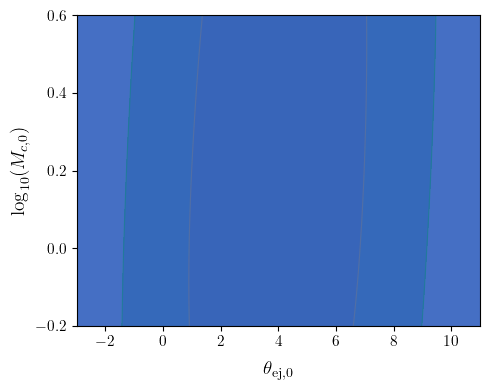

In [59]:
g = plots.get_single_plotter(width_inch=5, ratio=0.8)
g.settings.num_plot_contours = 1

# g.triangle_plot([chain_Y1, chain_Y6], params=chain_Y1.getParamNames().list()[:2], filled=True)
contour_args = {'filled': True, 'alpha': 0.7}
# g.plot_2d([chain_Y1, chain_Y6], 'theta_ej_0', 'mu_beta', filled=True, contour_args=contour_args, lims=[-3.0, 11.0, -0.2, 0.6])
g.plot_2d([chain_Y1, chain_Y6, chain_Y1_xipxim_only, chain_Y6_xipxim_only], 'theta_ej_0', 'mu_beta', filled=True, contour_args=contour_args, lims=[-3.0, 11.0, -0.2, 0.6])
# g.export('/mnt/home/spandey/ceph/GODMAX/notebooks/plots/theta_ej_0_mu_beta_forecast.pdf')



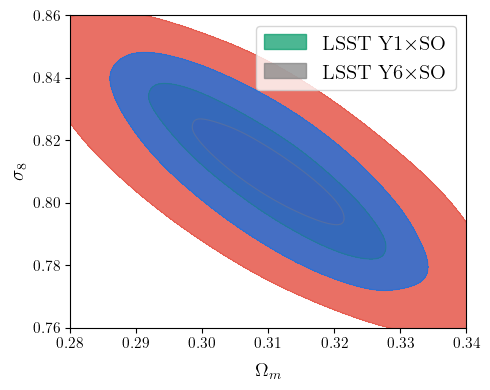

In [60]:
g = plots.get_single_plotter(width_inch=5, ratio=0.8)
g.settings.num_plot_contours = 1

# g.triangle_plot([chain_Y1, chain_Y6], params=chain_Y1.getParamNames().list()[:2], filled=True)
contour_args = {'filled': [True,  True, False, False], 'alpha': 0.7}
# g.plot_2d([chain_Y1, chain_Y6], 'Om0', 'sigma8', filled=True, contour_args=contour_args, lims=[0.28, 0.34, 0.76, 0.86])
g.plot_2d([chain_Y1, chain_Y6, chain_Y1_xipxim_only, chain_Y6_xipxim_only], 'Om0', 'sigma8', filled=True, contour_args=contour_args, lims=[0.28, 0.34, 0.76, 0.86])

# add fontsize=12 to the legend_kw argument to increase the legend font size
g.add_legend([r'LSST Y1$\times$SO', r'LSST Y6$\times$SO'], legend_loc='upper right', fontsize=15)
# g.export('/mnt/home/spandey/ceph/GODMAX/notebooks/plots/Om0_sigma8_forecast.pdf')




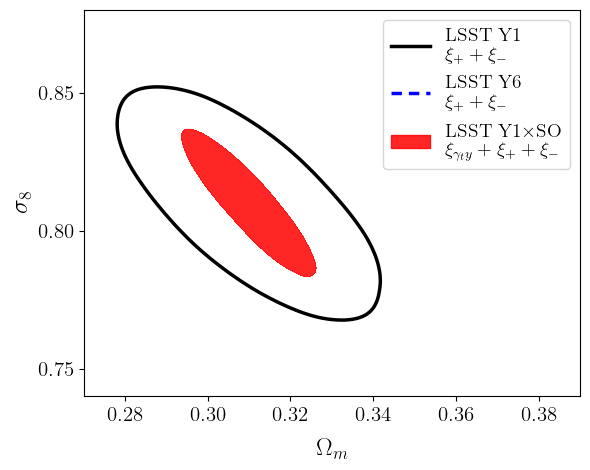

In [28]:
g = plots.getSinglePlotter(width_inch=6, ratio=0.8)
# g.settings.auto_ticks = True
g.settings.axes_fontsize   = 15
g.settings.lab_fontsize    = 18
g.settings.legend_fontsize = 18
g.settings.axis_marker_lw = 1.5
g.settings.num_plot_contours = 1

line_args = [{'lw':2.5,'color':'black'},{'lw':2.5,'color':'blue'},{'lw':0.1,'color':'red'},{'lw':0.1,'color':'green'},{'lw':2.5,'color':'orange'}]
all_samples = [chain_Y1_xipxim_only, chain_Y1_gty_only, chain_Y1]
# marker_dict = {'cosmological_parameters--omega_m':0.3,'cosmological_parameters--omega_mcb':Om_cb,'COSMOLOGICAL_PARAMETERS--SIGMA_8':0.8235,'cosmological_parameters--s8':s8v,'cosmological_parameters--omega_b':0.048,'cosmological_parameters--h0':0.69,'cosmological_parameters--n_s':0.97,'cosmological_parameters--w':-1.0, 'cosmological_parameters--omnuh2':0.00083 ,'pk_to_cl--b1e_bin1':1.7,'pk_to_cl--b1e_bin2':1.7,'pk_to_cl--b1e_bin3':1.7,'pk_to_cl--b1e_bin4':2.0,'pk_to_cl--b1e_bin5':2.0,'pk_to_cl--b2e_bin1':0.23,'pk_to_cl--b2e_bin2':0.23,'pk_to_cl--b2e_bin3':0.23,'pk_to_cl--b2e_bin4':0.5,'pk_to_cl--b2e_bin5':0.5}    
# g.plot_2d(all_samples,'cosmological_parameters--omega_m','cosmological_parameters--s8', legend_labels = legend_labels, line_args=[{'lw':2.5,'color':'black'},{'lw':2.5,'color':'blue'},{'lw':2.5,'color':'red'},{'lw':2.5,'color':'green'}],contour_lws=[1.5],  filled = [False, False,True, False], contour_colors = ['black','blue','red','green'],ls=['-','--','-.'],lims=[0.2,0.52,0.55,0.85])  
g.plot_2d(all_samples,'Om0', 'sigma8', 
          line_args=line_args,contour_lws=[1.5],  filled = [False, False,True, True, True], contour_colors = ['black','blue','red','green','orange']
          ,ls=['-','--','','',''] ,lims=[0.27, 0.39, 0.74, 0.88])  
# g.triangle_plot(all_samples, legend_labels = legend_labels, markers=marker_dict,  filled = [True,  True,True])  
# g.add_x_marker(0.3)
# g.add_y_marker(0.0)
# g.add_legend(legend_labels, legend_loc='center right',fontsize=18)
g.add_legend([r'LSST Y1' + '\n' + r'$\xi_{+} + \xi_{-}$', r'LSST Y6' + '\n' + r'$\xi_{+} + \xi_{-}$', r'LSST Y1$\times$SO' + '\n' + r'$\xi_{\gamma_t y} + \xi_{+} + \xi_{-}$', r'LSST Y6$\times$SO' + '\n' + r'$\xi_{\gamma_t y} + \xi_{+} + \xi_{-}$'], legend_loc='upper right', fontsize=14)

# g.export(fname = '/mnt/home/spandey/ceph/GODMAX/notebooks/plots/Om_sig8_forecast_all_REDUCEDSET.pdf')
# g.export(fname = '/mnt/home/spandey/ceph/GODMAX/notebooks/plots/Om_sig8_forecast_all_FINALSET.pdf')




((-229.64052262360332, 227.0382479218988),
 (-111.40982121251155, 121.01148484203402))

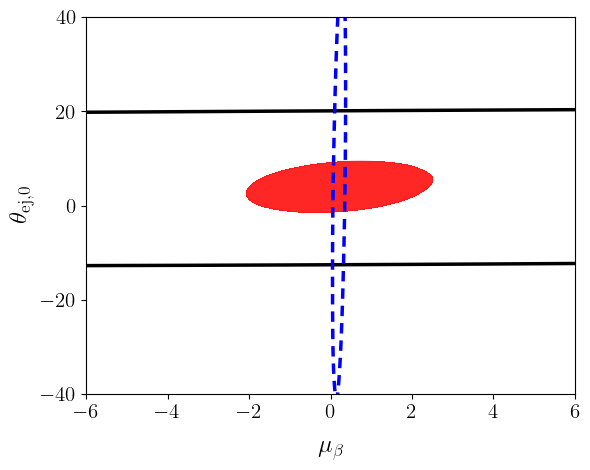

In [16]:
g = plots.getSinglePlotter(width_inch=6, ratio=0.8)
# g.settings.auto_ticks = True
g.settings.axes_fontsize   = 15
g.settings.lab_fontsize    = 18
g.settings.legend_fontsize = 18
g.settings.axis_marker_lw = 1.5
g.settings.num_plot_contours = 1
# ['theta_ej_0', 'theta_co_0','nu_z', 'gamma_rhogas','mu_beta', 'log10_Mc0','eta_star','alpha_nt']
line_args = [{'lw':2.5,'color':'black'},{'lw':2.5,'color':'blue'},{'lw':0.1,'color':'red'},{'lw':0.1,'color':'green'},{'lw':2.5,'color':'orange'}]
# all_samples = [chain_Y1_xipxim_only, chain_Y6_xipxim_only, chain_Y1, chain_Y6]
all_samples = [chain_Y1_xipxim_only, chain_Y1_gty_only, chain_Y1]
# marker_dict = {'cosmological_parameters--omega_m':0.3,'cosmological_parameters--omega_mcb':Om_cb,'COSMOLOGICAL_PARAMETERS--SIGMA_8':0.8235,'cosmological_parameters--s8':s8v,'cosmological_parameters--omega_b':0.048,'cosmological_parameters--h0':0.69,'cosmological_parameters--n_s':0.97,'cosmological_parameters--w':-1.0, 'cosmological_parameters--omnuh2':0.00083 ,'pk_to_cl--b1e_bin1':1.7,'pk_to_cl--b1e_bin2':1.7,'pk_to_cl--b1e_bin3':1.7,'pk_to_cl--b1e_bin4':2.0,'pk_to_cl--b1e_bin5':2.0,'pk_to_cl--b2e_bin1':0.23,'pk_to_cl--b2e_bin2':0.23,'pk_to_cl--b2e_bin3':0.23,'pk_to_cl--b2e_bin4':0.5,'pk_to_cl--b2e_bin5':0.5}    
# g.plot_2d(all_samples,'cosmological_parameters--omega_m','cosmological_parameters--s8', legend_labels = legend_labels, line_args=[{'lw':2.5,'color':'black'},{'lw':2.5,'color':'blue'},{'lw':2.5,'color':'red'},{'lw':2.5,'color':'green'}],contour_lws=[1.5],  filled = [False, False,True, False], contour_colors = ['black','blue','red','green'],ls=['-','--','-.'],lims=[0.2,0.52,0.55,0.85])  
g.plot_2d(all_samples,'mu_beta', 'theta_ej_0', 
          line_args=line_args,contour_lws=[1.5],  filled = [False, False,True, True, True], contour_colors = ['black','blue','red','green','orange']
          ,ls=['-','--','','',''], lims=[-6, 6, -40, 40.0])  
# g.triangle_plot(all_samples, legend_labels = legend_labels, markers=marker_dict,  filled = [True,  True,True])  
# g.add_x_marker(0.3)
# g.add_y_marker(0.0)
# g.add_legend(legend_labels, legend_loc='center right',fontsize=18)
# g.add_legend([r'LSST Y1' + '\n' + r'$\xi_{+} + \xi_{-}$', r'LSST Y6' + '\n' + r'$\xi_{+} + \xi_{-}$', r'LSST Y1$\times$SO' + '\n' + r'$\langle \gamma_t y \rangle + \xi_{+} + \xi_{-}$', r'LSST Y6$\times$SO' + '\n' + r'$\langle \gamma_t y \rangle + \xi_{+} + \xi_{-}$'], legend_loc='upper right', fontsize=14)

# g.export(fname = 'data_lcdm_comp.pdf')
# g.export(fname = '/mnt/home/spandey/ceph/GODMAX/notebooks/plots/thetaej_mubeta_forecast_all_REDUCEDSET.pdf')
# g.export(fname = '/mnt/home/spandey/ceph/GODMAX/notebooks/plots/thetaej_mubeta_forecast_all_FINALSET.pdf')



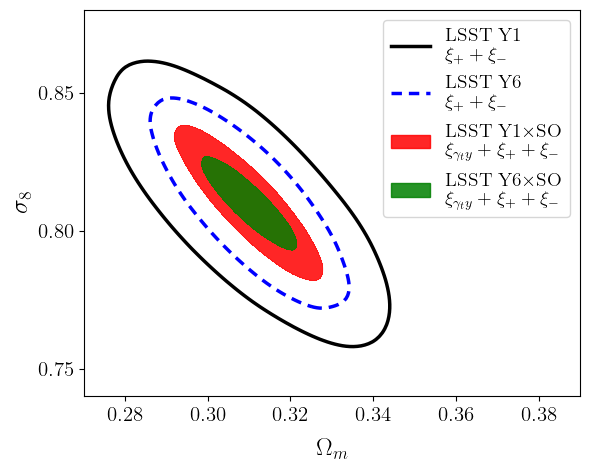

In [6]:
g = plots.getSinglePlotter(width_inch=6, ratio=0.8)
# g.settings.auto_ticks = True
g.settings.axes_fontsize   = 15
g.settings.lab_fontsize    = 18
g.settings.legend_fontsize = 18
g.settings.axis_marker_lw = 1.5
g.settings.num_plot_contours = 1

line_args = [{'lw':2.5,'color':'black'},{'lw':2.5,'color':'blue'},{'lw':0.1,'color':'red'},{'lw':0.1,'color':'green'},{'lw':2.5,'color':'orange'}]
all_samples = [chain_Y1_xipxim_only, chain_Y6_xipxim_only, chain_Y1, chain_Y6]
# marker_dict = {'cosmological_parameters--omega_m':0.3,'cosmological_parameters--omega_mcb':Om_cb,'COSMOLOGICAL_PARAMETERS--SIGMA_8':0.8235,'cosmological_parameters--s8':s8v,'cosmological_parameters--omega_b':0.048,'cosmological_parameters--h0':0.69,'cosmological_parameters--n_s':0.97,'cosmological_parameters--w':-1.0, 'cosmological_parameters--omnuh2':0.00083 ,'pk_to_cl--b1e_bin1':1.7,'pk_to_cl--b1e_bin2':1.7,'pk_to_cl--b1e_bin3':1.7,'pk_to_cl--b1e_bin4':2.0,'pk_to_cl--b1e_bin5':2.0,'pk_to_cl--b2e_bin1':0.23,'pk_to_cl--b2e_bin2':0.23,'pk_to_cl--b2e_bin3':0.23,'pk_to_cl--b2e_bin4':0.5,'pk_to_cl--b2e_bin5':0.5}    
# g.plot_2d(all_samples,'cosmological_parameters--omega_m','cosmological_parameters--s8', legend_labels = legend_labels, line_args=[{'lw':2.5,'color':'black'},{'lw':2.5,'color':'blue'},{'lw':2.5,'color':'red'},{'lw':2.5,'color':'green'}],contour_lws=[1.5],  filled = [False, False,True, False], contour_colors = ['black','blue','red','green'],ls=['-','--','-.'],lims=[0.2,0.52,0.55,0.85])  
g.plot_2d(all_samples,'Om0', 'sigma8', 
          line_args=line_args,contour_lws=[1.5],  filled = [False, False,True, True, True], contour_colors = ['black','blue','red','green','orange']
          ,ls=['-','--','','',''] ,lims=[0.27, 0.39, 0.74, 0.88])  
# g.triangle_plot(all_samples, legend_labels = legend_labels, markers=marker_dict,  filled = [True,  True,True])  
# g.add_x_marker(0.3)
# g.add_y_marker(0.0)
# g.add_legend(legend_labels, legend_loc='center right',fontsize=18)
g.add_legend([r'LSST Y1' + '\n' + r'$\xi_{+} + \xi_{-}$', r'LSST Y6' + '\n' + r'$\xi_{+} + \xi_{-}$', r'LSST Y1$\times$SO' + '\n' + r'$\xi_{\gamma_t y} + \xi_{+} + \xi_{-}$', r'LSST Y6$\times$SO' + '\n' + r'$\xi_{\gamma_t y} + \xi_{+} + \xi_{-}$'], legend_loc='upper right', fontsize=14)

# g.export(fname = '/mnt/home/spandey/ceph/GODMAX/notebooks/plots/Om_sig8_forecast_all_REDUCEDSET.pdf')
# g.export(fname = '/mnt/home/spandey/ceph/GODMAX/notebooks/plots/Om_sig8_forecast_all_FINALSET.pdf')



((-229.64052262360332, 227.0382479218988),
 (-39.42175357180959, 47.04822056553766))

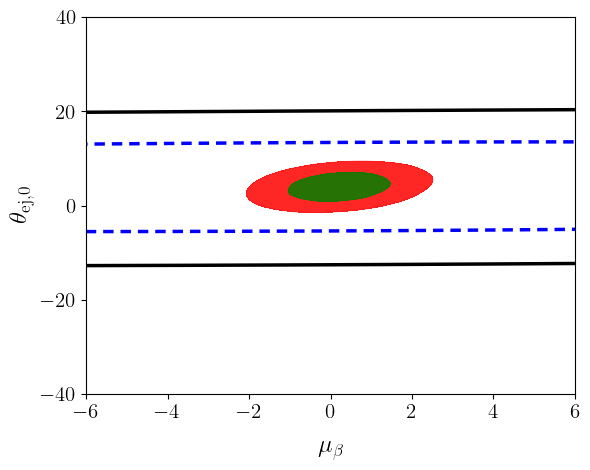

In [7]:
g = plots.getSinglePlotter(width_inch=6, ratio=0.8)
# g.settings.auto_ticks = True
g.settings.axes_fontsize   = 15
g.settings.lab_fontsize    = 18
g.settings.legend_fontsize = 18
g.settings.axis_marker_lw = 1.5
g.settings.num_plot_contours = 1
# ['theta_ej_0', 'theta_co_0','nu_z', 'gamma_rhogas','mu_beta', 'log10_Mc0','eta_star','alpha_nt']
line_args = [{'lw':2.5,'color':'black'},{'lw':2.5,'color':'blue'},{'lw':0.1,'color':'red'},{'lw':0.1,'color':'green'},{'lw':2.5,'color':'orange'}]
all_samples = [chain_Y1_xipxim_only, chain_Y6_xipxim_only, chain_Y1, chain_Y6]
# marker_dict = {'cosmological_parameters--omega_m':0.3,'cosmological_parameters--omega_mcb':Om_cb,'COSMOLOGICAL_PARAMETERS--SIGMA_8':0.8235,'cosmological_parameters--s8':s8v,'cosmological_parameters--omega_b':0.048,'cosmological_parameters--h0':0.69,'cosmological_parameters--n_s':0.97,'cosmological_parameters--w':-1.0, 'cosmological_parameters--omnuh2':0.00083 ,'pk_to_cl--b1e_bin1':1.7,'pk_to_cl--b1e_bin2':1.7,'pk_to_cl--b1e_bin3':1.7,'pk_to_cl--b1e_bin4':2.0,'pk_to_cl--b1e_bin5':2.0,'pk_to_cl--b2e_bin1':0.23,'pk_to_cl--b2e_bin2':0.23,'pk_to_cl--b2e_bin3':0.23,'pk_to_cl--b2e_bin4':0.5,'pk_to_cl--b2e_bin5':0.5}    
# g.plot_2d(all_samples,'cosmological_parameters--omega_m','cosmological_parameters--s8', legend_labels = legend_labels, line_args=[{'lw':2.5,'color':'black'},{'lw':2.5,'color':'blue'},{'lw':2.5,'color':'red'},{'lw':2.5,'color':'green'}],contour_lws=[1.5],  filled = [False, False,True, False], contour_colors = ['black','blue','red','green'],ls=['-','--','-.'],lims=[0.2,0.52,0.55,0.85])  
g.plot_2d(all_samples,'mu_beta', 'theta_ej_0', 
          line_args=line_args,contour_lws=[1.5],  filled = [False, False,True, True, True], contour_colors = ['black','blue','red','green','orange']
          ,ls=['-','--','','',''], lims=[-6, 6, -40, 40.0])  
# g.triangle_plot(all_samples, legend_labels = legend_labels, markers=marker_dict,  filled = [True,  True,True])  
# g.add_x_marker(0.3)
# g.add_y_marker(0.0)
# g.add_legend(legend_labels, legend_loc='center right',fontsize=18)
# g.add_legend([r'LSST Y1' + '\n' + r'$\xi_{+} + \xi_{-}$', r'LSST Y6' + '\n' + r'$\xi_{+} + \xi_{-}$', r'LSST Y1$\times$SO' + '\n' + r'$\langle \gamma_t y \rangle + \xi_{+} + \xi_{-}$', r'LSST Y6$\times$SO' + '\n' + r'$\langle \gamma_t y \rangle + \xi_{+} + \xi_{-}$'], legend_loc='upper right', fontsize=14)

# g.export(fname = 'data_lcdm_comp.pdf')
# g.export(fname = '/mnt/home/spandey/ceph/GODMAX/notebooks/plots/thetaej_mubeta_forecast_all_REDUCEDSET.pdf')
# g.export(fname = '/mnt/home/spandey/ceph/GODMAX/notebooks/plots/thetaej_mubeta_forecast_all_FINALSET.pdf')



In [14]:
FoM_y1_all = 1/np.sqrt(np.linalg.det(chain_Y1.getCov(pars=[0,4])))
FoM_y6_all = 1/np.sqrt(np.linalg.det(chain_Y6.getCov(pars=[0,4])))
 

In [15]:
FoM_y1_xipm = 1/np.sqrt(np.linalg.det(chain_Y1_xipxim_only.getCov(pars=[0,4])))
FoM_y6_xipm = 1/np.sqrt(np.linalg.det(chain_Y6_xipxim_only.getCov(pars=[0,4])))


In [16]:
FoM_y1_all/FoM_y1_xipm, FoM_y6_all/FoM_y6_xipm



(4.843265291335851, 6.262105443836246)

In [22]:
FoM_y6_xipm/FoM_y1_xipm


2.095184715769087

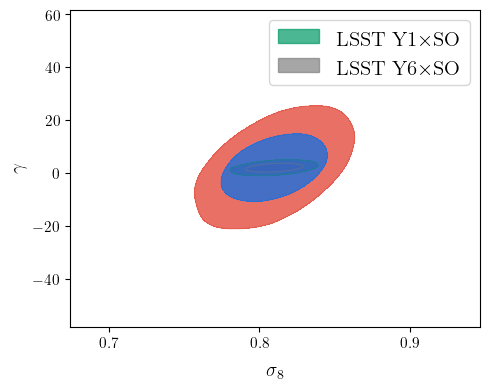

In [17]:
g = plots.get_single_plotter(width_inch=5, ratio=0.8)
g.settings.num_plot_contours = 1

# g.triangle_plot([chain_Y1, chain_Y6], params=chain_Y1.getParamNames().list()[:2], filled=True)
contour_args = {'filled': True, 'alpha': 0.7}
# g.plot_2d([chain_Y1, chain_Y6], 'Om0', 'sigma8', filled=True, contour_args=contour_args, lims=[0.28, 0.34, 0.76, 0.86])
g.plot_2d([chain_Y1, chain_Y6, chain_Y1_xipxim_only, chain_Y6_xipxim_only], 'sigma8', 'gamma_rhogas', filled=True, contour_args=contour_args)

# add fontsize=12 to the legend_kw argument to increase the legend font size
g.add_legend([r'LSST Y1$\times$SO', r'LSST Y6$\times$SO'], legend_loc='upper right', fontsize=15)
# g.export('/mnt/home/spandey/ceph/GODMAX/notebooks/plots/Om0_sigma8_forecast.pdf')




((-0.6475058546207291, 1.0627969539217803),
 (-3.004263719907084, 2.661837923970693))

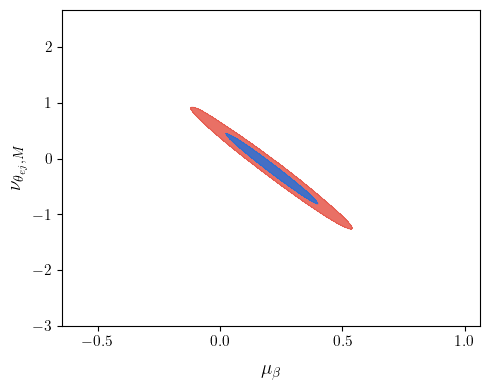

In [76]:
g = plots.get_single_plotter(width_inch=5, ratio=0.8)
g.settings.num_plot_contours = 1
# sims_params_vary_names = ['theta_ej_0', 'theta_co_0','nu_z', 'gamma_rhogas','mu_beta','nu_theta_ej_M','eta_star','alpha_nt']
# g.triangle_plot([chain_Y1, chain_Y6], params=chain_Y1.getParamNames().list()[:2], filled=True)
contour_args = {'filled': True, 'alpha': 0.7}
g.plot_2d([chain_Y1, chain_Y6], 'mu_beta', 'nu_theta_ej_M', filled=True, contour_args=contour_args)



In [12]:
saved_plot_data_all = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/ANTILES/fitting_results_all_sims_wparams_REDUCEDSET4.pkl','rb'))
# len(saved_plot_data_all.keys())
params_all = np.zeros((len(saved_plot_data_all.keys()), len(sims_params_vary_names)))
for i, key in enumerate(saved_plot_data_all.keys()):
    params_all[i,:] = saved_plot_data_all[key]['params_bestfit']


In [13]:
sims_params_vary_names = ['theta_ej_0', 'theta_co_0','nu_z', 'gamma_rhogas','mu_beta','nu_theta_ej_M','eta_star','alpha_nt']
sim_param_labels = [r'$\theta_{\rm ej,0}$', r'$\theta_{\rm co,0}$', r'$\nu_z$', r'$\gamma$', r'$\mu_{\beta}$', r'$\nu_{\theta_{ej},M}$', r'$\eta_{\star}$', r'$\alpha_{nt}$']


antiles_bestfit = MCSamples(samples=params_all, names=sims_params_vary_names,
                           labels=sim_param_labels, name_tag=r'ANTILES',settings=settings)



Removed no burn in


[[1.4306702444397144, 8.312825226455251],
 [-0.03999999999895001, 0.83999999999995]]

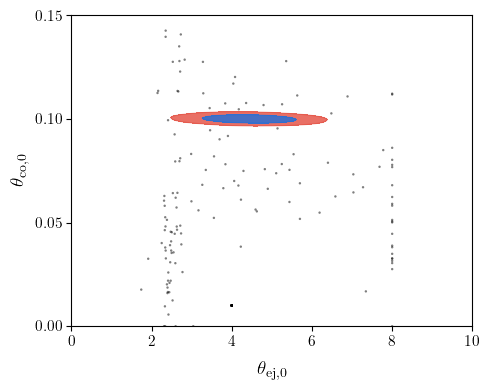

In [17]:
g = plots.get_single_plotter(width_inch=5, ratio=0.8)
g.settings.num_plot_contours = 1

# g.triangle_plot([chain_Y1, chain_Y6], params=chain_Y1.getParamNames().list()[:2], filled=True)
contour_args = {'filled': True, 'alpha': 0.7}
g.plot_2d([chain_Y1, chain_Y6], 'theta_ej_0', 'theta_co_0', filled=True, contour_args=contour_args, lims=[0.0, 10.0, -0.0, 0.15])
# g.export('/mnt/home/spandey/ceph/GODMAX/notebooks/plots/theta_ej_0_mu_beta_forecast.pdf')
g.add_2d_scatter(antiles_bestfit, 'theta_ej_0', 'theta_co_0', alpha=0.5)



In [29]:
# samples_Y1 = np.load('/mnt/home/spandey/ceph/GODMAX/data/DES_Y1_3x2pt_chain.npy')
import pickle as pk
# samples_Y1 = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y1.pk', 'rb'))['samples']
# samples_Y6 = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y6.pk', 'rb'))['samples']

F_Y1 = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y1_FINALSET_wFcov.pk', 'rb'))['F_all']
# samples_Y6 = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y6_FINALSET.pk', 'rb'))['samples']

F_Y1_xipxim_only = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y1_FINALSET_xipxim_only_wFcov.pk', 'rb'))['F_all']
# samples_Y6_xipxim_only = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y6_FINALSET_xipxim_only.pk', 'rb'))['samples']

F_Y1_gty_only = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y1_FINALSET_gty_only_wFcov.pk', 'rb'))['F_all']
# samples_Y6_xipxim_only = pk.load(open('/mnt/home/spandey/ceph/GODMAX/data/forecast/samples_Y6_FINALSET_xipxim_only.pk', 'rb'))['samples']




In [31]:
# F_Y1_xipxim_only.shape
fid_params_all = np.array([ 3.10e-01,  4.90e-02,  6.72e+01,  9.50e-01,  8.10e-01,  4.00e+00,
        1.00e-01, -2.50e+00,  5.00e-02,  2.00e+00,  2.10e-01,  1.50e+01,
        3.00e-01,  1.80e-01, -2.00e-01,  1.00e-01,  0.00e+00,  0.00e+00,
        0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,
        0.00e+00,  0.00e+00,  0.00e+00])


In [50]:
# cov = np.linalg.inv(F_all)
# mean = fid_params_all
# get samples from this multi dimensional gaussian
# samples = np.random.multivariate_normal(mean, cov, 100000)
# F_Y1_xipxim_only_fixDMB = F_Y1_xipxim_only[0:5+15:27, 0:5+15:27]
# F_Y1_xipxim_only_fixDMB = F_Y1_xipxim_only[0:5+15:27, :][:, 0:5+15:27]
F_Y1_xipxim_only_fixDMB = np.zeros((5+12, 5+12))
F_Y1_xipxim_only_fixDMB[0:5, 0:5] = F_Y1_xipxim_only[0:5, 0:5]
F_Y1_xipxim_only_fixDMB[5:, 5:] = F_Y1_xipxim_only[15:, 15:]
F_Y1_xipxim_only_fixDMB[5:, 0:5] = F_Y1_xipxim_only[15:, 0:5]
F_Y1_xipxim_only_fixDMB[0:5, 5:] = F_Y1_xipxim_only[0:5, 15:]
cov_xipxim_only_fixDMB = np.linalg.inv(F_Y1_xipxim_only_fixDMB)
mean_xipxim_only_fixDMB = np.array(fid_params_all[0:5].tolist() + fid_params_all[15:].tolist())
# get samples from this multi dimensional gaussian
samples_xipxim_only_fixDMB = np.random.multivariate_normal(mean_xipxim_only_fixDMB, cov_xipxim_only_fixDMB, 100000)



In [54]:
# cov = np.linalg.inv(F_all)
# mean = fid_params_all
# get samples from this multi dimensional gaussian
# samples = np.random.multivariate_normal(mean, cov, 100000)
# F_Y1_xipxim_only_fixDMB = F_Y1_xipxim_only[0:5+15:27, 0:5+15:27]
# F_Y1_xipxim_only_fixDMB = F_Y1_xipxim_only[0:5+15:27, :][:, 0:5+15:27]
F_Y1_fixDMB = np.zeros((5+12, 5+12))
F_Y1_fixDMB[0:5, 0:5] = F_Y1_xipxim_only[0:5, 0:5]
F_Y1_fixDMB[5:, 5:] = F_Y1_xipxim_only[15:, 15:]
F_Y1_fixDMB[5:, 0:5] = F_Y1_xipxim_only[15:, 0:5]
F_Y1_fixDMB[0:5, 5:] = F_Y1_xipxim_only[0:5, 15:]
cov_fixDMB = np.linalg.inv(F_Y1_fixDMB)
mean_fixDMB = np.array(fid_params_all[0:5].tolist() + fid_params_all[15:].tolist())
# get samples from this multi dimensional gaussian
samples_fixDMB = np.random.multivariate_normal(mean_fixDMB, cov_fixDMB, 100000)



In [52]:
chain_Y1_xipxim_only_fixDMB = MCSamples(samples=samples_xipxim_only_fixDMB, names=param_names[0:5]+param_names[15:27],
                           labels=param_labels[0:5]+param_labels[15:27], name_tag=r'LSST Y1$\times$SO',settings=settings)



Removed no burn in


In [55]:
chain_Y1_fixDMB = MCSamples(samples=samples_fixDMB, names=param_names[0:5]+param_names[15:27],
                           labels=param_labels[0:5]+param_labels[15:27], name_tag=r'LSST Y1$\times$SO',settings=settings)



Removed no burn in


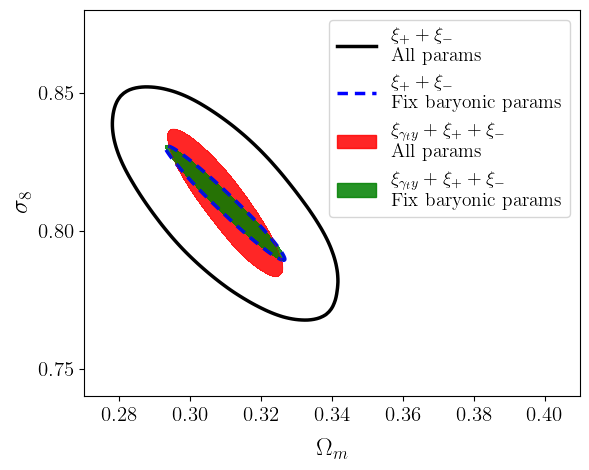

In [60]:
g = plots.getSinglePlotter(width_inch=6, ratio=0.8)
# g.settings.auto_ticks = True
g.settings.axes_fontsize   = 15
g.settings.lab_fontsize    = 18
g.settings.legend_fontsize = 18
g.settings.axis_marker_lw = 1.5
g.settings.num_plot_contours = 1

line_args = [{'lw':2.5,'color':'black'},{'lw':2.5,'color':'blue'},{'lw':0.1,'color':'red'},{'lw':0.1,'color':'green'},{'lw':2.5,'color':'orange'}]
all_samples = [chain_Y1_xipxim_only, chain_Y1_xipxim_only_fixDMB, chain_Y1, chain_Y1_fixDMB]
# marker_dict = {'cosmological_parameters--omega_m':0.3,'cosmological_parameters--omega_mcb':Om_cb,'COSMOLOGICAL_PARAMETERS--SIGMA_8':0.8235,'cosmological_parameters--s8':s8v,'cosmological_parameters--omega_b':0.048,'cosmological_parameters--h0':0.69,'cosmological_parameters--n_s':0.97,'cosmological_parameters--w':-1.0, 'cosmological_parameters--omnuh2':0.00083 ,'pk_to_cl--b1e_bin1':1.7,'pk_to_cl--b1e_bin2':1.7,'pk_to_cl--b1e_bin3':1.7,'pk_to_cl--b1e_bin4':2.0,'pk_to_cl--b1e_bin5':2.0,'pk_to_cl--b2e_bin1':0.23,'pk_to_cl--b2e_bin2':0.23,'pk_to_cl--b2e_bin3':0.23,'pk_to_cl--b2e_bin4':0.5,'pk_to_cl--b2e_bin5':0.5}    
# g.plot_2d(all_samples,'cosmological_parameters--omega_m','cosmological_parameters--s8', legend_labels = legend_labels, line_args=[{'lw':2.5,'color':'black'},{'lw':2.5,'color':'blue'},{'lw':2.5,'color':'red'},{'lw':2.5,'color':'green'}],contour_lws=[1.5],  filled = [False, False,True, False], contour_colors = ['black','blue','red','green'],ls=['-','--','-.'],lims=[0.2,0.52,0.55,0.85])  
g.plot_2d(all_samples,'Om0', 'sigma8', 
          line_args=line_args,contour_lws=[1.5],  filled = [False, False,True, True, True], contour_colors = ['black','blue','red','green','orange']
          ,ls=['-','--','','',''] ,lims=[0.27, 0.41, 0.74, 0.88])  
# g.triangle_plot(all_samples, legend_labels = legend_labels, markers=marker_dict,  filled = [True,  True,True])  
# g.add_x_marker(0.3)
# g.add_y_marker(0.0)
# g.add_legend(legend_labels, legend_loc='center right',fontsize=18)
# g.add_legend([r'LSST Y1' + '\n' + r'$\xi_{+} + \xi_{-}$', r'LSST Y6' + '\n' + r'$\xi_{+} + \xi_{-}$', r'LSST Y1$\times$SO' + '\n' + r'$\xi_{\gamma_t y} + \xi_{+} + \xi_{-}$', r'LSST Y6$\times$SO' + '\n' + r'$\xi_{\gamma_t y} + \xi_{+} + \xi_{-}$'], legend_loc='upper right', fontsize=14)
g.add_legend([r'$\xi_{+} + \xi_{-}$' + '\n' + r'All params', r'$\xi_{+} + \xi_{-}$' + '\n' + r'Fix baryonic params', r'$\xi_{\gamma_t y} + \xi_{+} + \xi_{-}$' + '\n' + r'All params', r'$\xi_{\gamma_t y} + \xi_{+} + \xi_{-}$' + '\n' + r'Fix baryonic params'], legend_loc='upper right', fontsize=14)

# g.export(fname = '/mnt/home/spandey/ceph/GODMAX/notebooks/plots/Om_sig8_forecast_all_REDUCEDSET.pdf')
# g.export(fname = '/mnt/home/spandey/ceph/GODMAX/notebooks/plots/Om_sig8_forecast_all_FINALSET.pdf')




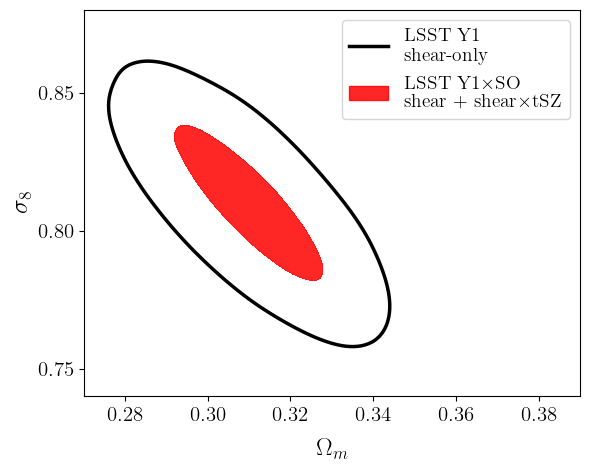

In [10]:
g = plots.getSinglePlotter(width_inch=6, ratio=0.8)
# g.settings.auto_ticks = True
g.settings.axes_fontsize   = 15
g.settings.lab_fontsize    = 18
g.settings.legend_fontsize = 18
g.settings.axis_marker_lw = 1.5
g.settings.num_plot_contours = 1

line_args = [{'lw':2.5,'color':'black'},{'lw':0.1,'color':'red'},{'lw':0.1,'color':'green'},{'lw':2.5,'color':'orange'}]
all_samples = [chain_Y1_xipxim_only, chain_Y1]
# marker_dict = {'cosmological_parameters--omega_m':0.3,'cosmological_parameters--omega_mcb':Om_cb,'COSMOLOGICAL_PARAMETERS--SIGMA_8':0.8235,'cosmological_parameters--s8':s8v,'cosmological_parameters--omega_b':0.048,'cosmological_parameters--h0':0.69,'cosmological_parameters--n_s':0.97,'cosmological_parameters--w':-1.0, 'cosmological_parameters--omnuh2':0.00083 ,'pk_to_cl--b1e_bin1':1.7,'pk_to_cl--b1e_bin2':1.7,'pk_to_cl--b1e_bin3':1.7,'pk_to_cl--b1e_bin4':2.0,'pk_to_cl--b1e_bin5':2.0,'pk_to_cl--b2e_bin1':0.23,'pk_to_cl--b2e_bin2':0.23,'pk_to_cl--b2e_bin3':0.23,'pk_to_cl--b2e_bin4':0.5,'pk_to_cl--b2e_bin5':0.5}    
# g.plot_2d(all_samples,'cosmological_parameters--omega_m','cosmological_parameters--s8', legend_labels = legend_labels, line_args=[{'lw':2.5,'color':'black'},{'lw':2.5,'color':'blue'},{'lw':2.5,'color':'red'},{'lw':2.5,'color':'green'}],contour_lws=[1.5],  filled = [False, False,True, False], contour_colors = ['black','blue','red','green'],ls=['-','--','-.'],lims=[0.2,0.52,0.55,0.85])  
g.plot_2d(all_samples,'Om0', 'sigma8', 
          line_args=line_args,contour_lws=[1.5],  filled = [False,True, True, True], contour_colors = ['black','red','green','orange']
          ,ls=['-','-','','',''] ,lims=[0.27, 0.39, 0.74, 0.88])  
# g.triangle_plot(all_samples, legend_labels = legend_labels, markers=marker_dict,  filled = [True,  True,True])  
# g.add_x_marker(0.3)
# g.add_y_marker(0.0)
# g.add_legend(legend_labels, legend_loc='center right',fontsize=18)
g.add_legend([r'LSST Y1' + '\n' + r'shear-only', r'LSST Y1$\times$SO' + '\n' + r'shear + shear$\times$tSZ'], legend_loc='upper right', fontsize=14)

# g.export(fname = '/mnt/home/spandey/ceph/GODMAX/notebooks/plots/Om_sig8_forecast_all_REDUCEDSET.pdf')
# g.export(fname = '/mnt/home/spandey/ceph/GODMAX/notebooks/plots/Om_sig8_forecast_all_FINALSET.pdf')



((-229.64052262360332, 227.0382479218988),
 (-39.42175357180959, 47.04822056553766))

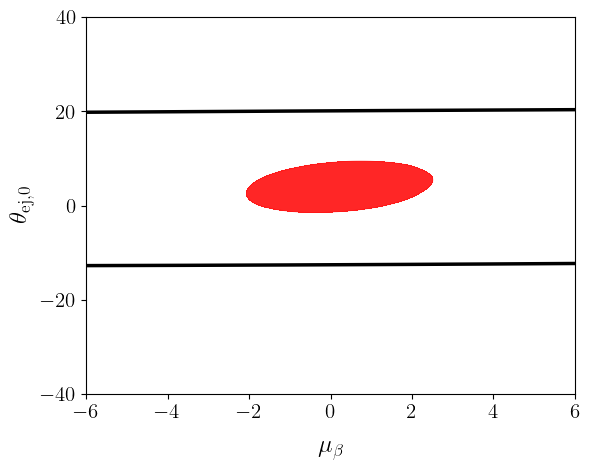

In [11]:
g = plots.getSinglePlotter(width_inch=6, ratio=0.8)
# g.settings.auto_ticks = True
g.settings.axes_fontsize   = 15
g.settings.lab_fontsize    = 18
g.settings.legend_fontsize = 18
g.settings.axis_marker_lw = 1.5
g.settings.num_plot_contours = 1
# ['theta_ej_0', 'theta_co_0','nu_z', 'gamma_rhogas','mu_beta', 'log10_Mc0','eta_star','alpha_nt']
line_args = [{'lw':2.5,'color':'black'},{'lw':0.1,'color':'red'},{'lw':0.1,'color':'green'},{'lw':2.5,'color':'orange'}]
all_samples = [chain_Y1_xipxim_only, chain_Y1]
# marker_dict = {'cosmological_parameters--omega_m':0.3,'cosmological_parameters--omega_mcb':Om_cb,'COSMOLOGICAL_PARAMETERS--SIGMA_8':0.8235,'cosmological_parameters--s8':s8v,'cosmological_parameters--omega_b':0.048,'cosmological_parameters--h0':0.69,'cosmological_parameters--n_s':0.97,'cosmological_parameters--w':-1.0, 'cosmological_parameters--omnuh2':0.00083 ,'pk_to_cl--b1e_bin1':1.7,'pk_to_cl--b1e_bin2':1.7,'pk_to_cl--b1e_bin3':1.7,'pk_to_cl--b1e_bin4':2.0,'pk_to_cl--b1e_bin5':2.0,'pk_to_cl--b2e_bin1':0.23,'pk_to_cl--b2e_bin2':0.23,'pk_to_cl--b2e_bin3':0.23,'pk_to_cl--b2e_bin4':0.5,'pk_to_cl--b2e_bin5':0.5}    
# g.plot_2d(all_samples,'cosmological_parameters--omega_m','cosmological_parameters--s8', legend_labels = legend_labels, line_args=[{'lw':2.5,'color':'black'},{'lw':2.5,'color':'blue'},{'lw':2.5,'color':'red'},{'lw':2.5,'color':'green'}],contour_lws=[1.5],  filled = [False, False,True, False], contour_colors = ['black','blue','red','green'],ls=['-','--','-.'],lims=[0.2,0.52,0.55,0.85])  
g.plot_2d(all_samples,'mu_beta', 'theta_ej_0',
          line_args=line_args,contour_lws=[1.5],  filled = [False,True, True, True], contour_colors = ['black','red','green','orange']
          ,ls=['-','-','','',''] ,lims=[-6, 6, -40, 40.0])   
        #   line_args=line_args,contour_lws=[1.5],  filled = [False, False,True, True, True], contour_colors = ['black','blue','red','green','orange']
        #   ,ls=['-','--','','',''], lims=[-6, 6, -40, 40.0])  
# g.triangle_plot(all_samples, legend_labels = legend_labels, markers=marker_dict,  filled = [True,  True,True])  
# g.add_x_marker(0.3)
# g.add_y_marker(0.0)
# g.add_legend(legend_labels, legend_loc='center right',fontsize=18)
# g.add_legend([r'LSST Y1' + '\n' + r'$\xi_{+} + \xi_{-}$', r'LSST Y6' + '\n' + r'$\xi_{+} + \xi_{-}$', r'LSST Y1$\times$SO' + '\n' + r'$\langle \gamma_t y \rangle + \xi_{+} + \xi_{-}$', r'LSST Y6$\times$SO' + '\n' + r'$\langle \gamma_t y \rangle + \xi_{+} + \xi_{-}$'], legend_loc='upper right', fontsize=14)

# g.export(fname = 'data_lcdm_comp.pdf')
# g.export(fname = '/mnt/home/spandey/ceph/GODMAX/notebooks/plots/thetaej_mubeta_forecast_all_REDUCEDSET.pdf')
# g.export(fname = '/mnt/home/spandey/ceph/GODMAX/notebooks/plots/thetaej_mubeta_forecast_all_FINALSET.pdf')

